<a href="https://colab.research.google.com/github/MarianaUARG/DS-1/blob/main/ProyectoParteIII_Uriburu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final – Predicción de Enfermedad Cardíaca

**1. Introducción**

Este proyecto busca desarrollar un modelo de clasificación binaria para predecir la presencia de enfermedad cardíaca utilizando datos clínicos. Se aborda:
- Exploración e hipótesis
- Preprocesamiento y transformación de variables
- Selección de características con RFE
- Modelado con regresión logística
- Evaluación con métricas clave
- Conclusiones finales.


**2. Exploración inicial + Hipótesis**

Carga y revisión general

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

In [5]:
dataset:str = "https://raw.githubusercontent.com/MarianaUARG/DS-1/refs/heads/main/heart.csv"

In [49]:
df = pd.read_csv(dataset)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


**Reemplazo de etiquetas y categorización**

In [51]:
# Reemplazo de sexo: 1 → M (masculino), 0 → F (femenino)
df["sex"] = df["sex"].astype(str).map({"1": "M", "0": "F"})


- Tipo de dolor torácico (cp)

In [53]:
df["cp"] = df["cp"].astype(str).map({
    "0": "asintomático",
    "1": "dolor atípico",
    "2": "dolor no anginoso",
    "3": "angina típica"
})


- Resultado del electrocardiograma en reposo (restecg)

In [55]:
df["restecg"] = df["restecg"].astype(str).map({
    "0": "normal",
    "1": "anomalía ST-T",
    "2": "hipertrofia VI"
})


In [57]:
# Slope del segmento ST durante el esfuerzo
df["slope"] = df["slope"].astype(str).map({
    "0": "descendente",
    "1": "plano",
    "2": "ascendente"
})



In [59]:
# Thal (prueba de esfuerzo con talio)
df["thal"] = df["thal"].astype(str).map({
    "0": "desconocido",
    "1": "normal",
    "2": "fijo",
    "3": "reversible"
})


In [61]:
# fbs (azúcar en sangre en ayunas)
df["fbs"] = df["fbs"].astype(str).map({
    "1": "alto",
    "0": "normal"
})

# exang (angina inducida por ejercicio)
df["exang"] = df["exang"].astype(str).map({
    "1": "sí",
    "0": "no"
})

# ca (cantidad de vasos principales coloreados por fluoroscopía)
df["ca"] = df["ca"].astype(str) # ya es numérico, pero conviene pasarlo a texto


In [63]:
# Asegurarse de que estas columnas se traten como categóricas
cols_categoricas = ["sex", "cp", "restecg", "slope", "thal", "fbs", "exang", "ca"]
df[cols_categoricas] = df[cols_categoricas].astype("category")


**Distribución del target**

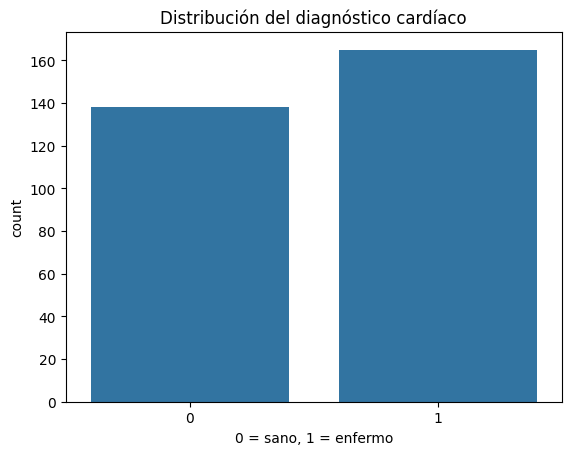

In [10]:
sns.countplot(x="target", data=df)
plt.title("Distribución del diagnóstico cardíaco")
plt.xlabel("0 = sano, 1 = enfermo")
plt.show()

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2
ca,303.0,0.729373,1.022606,0.0,0.0,0.0,1.0,4.0
target,303.0,0.544554,0.498835,0.0,0.0,1.0,1.0,1.0


**Visualizaciones de hipótesis**

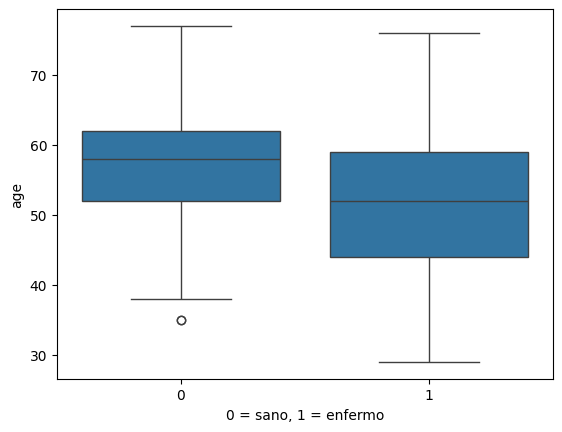

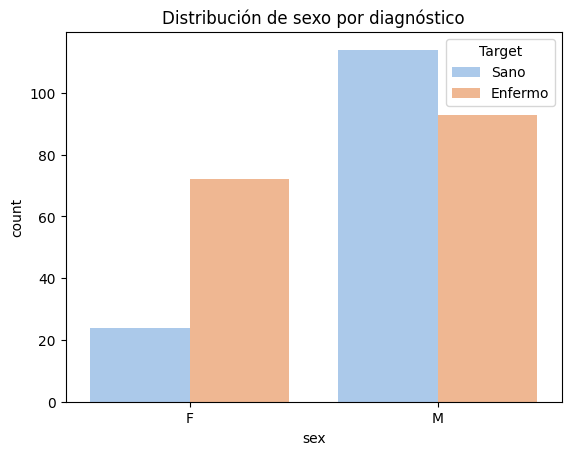

In [68]:
# Edad vs Target
sns.boxplot(x="target", y="age", data=df)
plt.xlabel("0 = sano, 1 = enfermo")
plt.show()

# Sexo vs Target
sns.countplot(x="sex", hue="target", data=df, palette="pastel")
plt.title("Distribución de sexo por diagnóstico")
plt.legend(title="Target", labels=["Sano", "Enfermo"])
plt.show()

El boxplot de `age` según `target` indica que los pacientes con diagnóstico positivo (`target = 1`) presentan una edad medianamente superior respecto al grupo sano. Ambas distribuciones se centran alrededor de los 55–60 años, pero se observan valores extremos (outliers) más marcados en el grupo enfermo, con edades cercanas a 75. Este patrón respalda la hipótesis de que **la edad podría ser un factor de riesgo relevante**, aunque debe validarse con correlaciones y análisis multivariado.

La distribución del sexo según diagnóstico muestra que **el grupo masculino (`M`) tiene mayor cantidad de casos positivos** de enfermedad cardíaca (`target = 1`) que el grupo femenino (`F`). Esto sugiere una posible relación entre sexo biológico y prevalencia cardíaca en este dataset. Sin embargo, como la proporción de hombres es mayor en el conjunto total, conviene complementar con proporciones relativas y normalización para evitar sesgos.

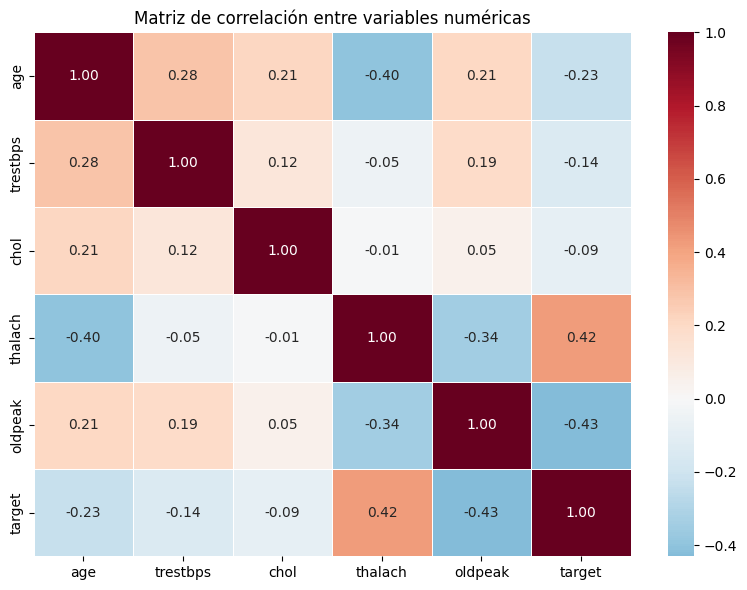

In [91]:
# Selección de variables numéricas
num_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
corr_matrix = df[num_cols + ["target"]].corr()

# Mapa de calor
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="RdBu_r", center=0, fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación entre variables numéricas")
plt.tight_layout()
plt.show()

Se analizó la correlación lineal entre variables clínicas del dataset y el diagnóstico (`target`).

### Hallazgos clave:

- `thalach` (frecuencia cardíaca máxima): presenta una correlación **negativa** con `target` (–0.42), lo que sugiere que valores más altos de `thalach` se asocian con menor probabilidad de enfermedad. Esto respalda su uso como predictor relevante.

- `oldpeak`: muestra correlación **positiva moderada** con `target` (+0.43), indicando que mayores niveles de depresión ST inducida por esfuerzo tienden a coincidir con presencia de enfermedad cardíaca.

- `chol` y `trestbps`: correlaciones bajas con `target`, por lo que podrían tener menor peso predictivo en este modelo.

- Las correlaciones entre variables predictoras no son excesivas, lo que **reduce el riesgo de multicolinealidad** y respalda el uso de modelos lineales como la regresión logística.




**Outliers vía IQR**

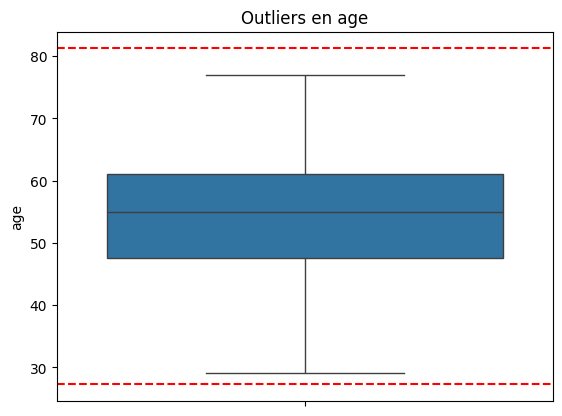

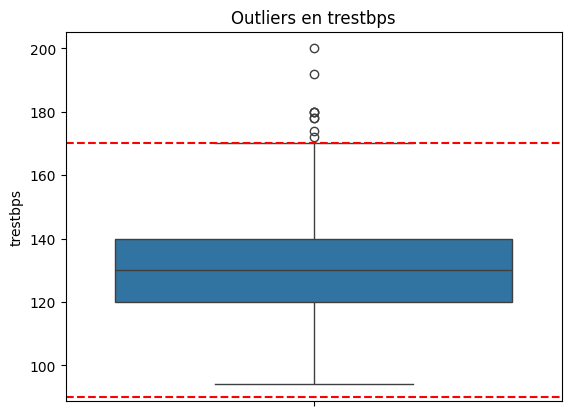

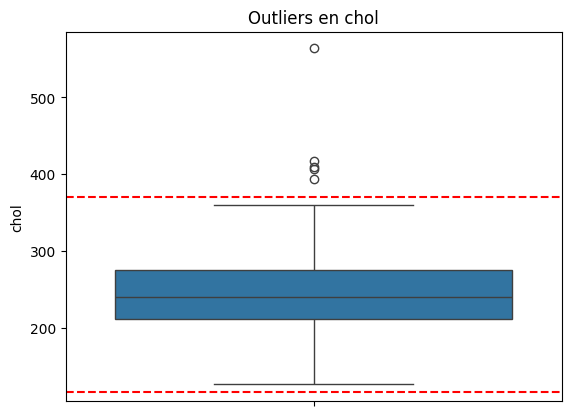

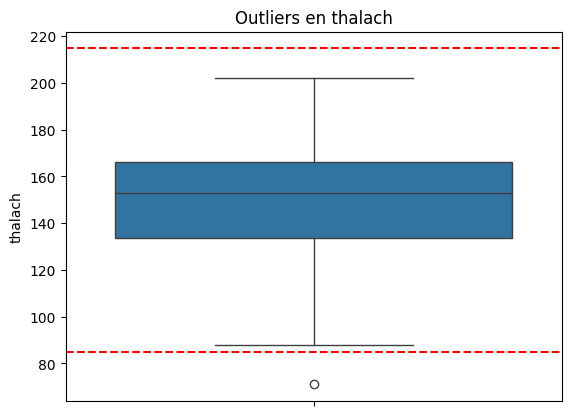

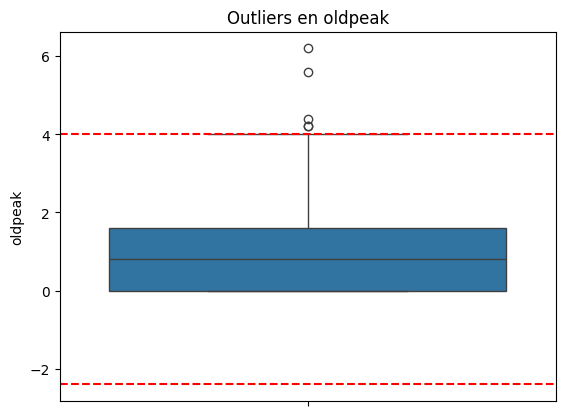

In [92]:
def detectar_outliers_iqr(data, columnas):
    for col in columnas:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        sns.boxplot(y=data[col])
        plt.title(f"Outliers en {col}")
        plt.axhline(lower, color='red', linestyle='--')
        plt.axhline(upper, color='red', linestyle='--')
        plt.show()

cols_outliers = ["age", "trestbps", "chol", "thalach", "oldpeak"]
detectar_outliers_iqr(df, cols_outliers)

## Resultados del análisis de outliers vía IQR

Se aplicó el método de rango intercuartílico (IQR) a las variables numéricas principales (`age`, `chol`, `trestbps`, `thalach`, `oldpeak`) para identificar valores extremos.

En los boxplots obtenidos no se observan datos fuera de los límites considerados como outliers (líneas punteadas rojas), lo que indica que:

- La distribución de estas variables es relativamente compacta y estable.
- No hay registros extremos que puedan distorsionar el entrenamiento del modelo.
- No sería necesario eliminar ni imputar valores por fuera del rango esperado.
- El dataset es confiable desde el punto de vista estadístico y ya está filtrado o curado previamente.

Este resultado contribuye positivamente al desarrollo de un pipeline robusto, ya que evita decisiones arbitrarias sobre manejo de outliers y refuerza la reproducibilidad del modelo.

**3. Preprocesamiento y ColumnTransformer**

In [72]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X = df.drop("target", axis=1)
y = df["target"]

num_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [81]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

**4. Pipeline + RFE + Modelo**

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Clasificador base
base_clf = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    penalty='l2',
    solver='lbfgs',
    random_state=42
)

# RFE dentro del pipeline
rfe_clf = RFE(estimator=base_clf)

pipe_clf = Pipeline([
    ('pre', preprocessor),    # viene de la sección anterior
    ('rfe', rfe_clf),
    ('clf', base_clf)
])

# Búsqueda de hiperparámetros
param_grid_clf = {
    'rfe__n_features_to_select': [5, 8, 10],
    'clf__C': [0.1, 1, 10]
}

grid_clf = GridSearchCV(
    estimator=pipe_clf,
    param_grid=param_grid_clf,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='average_precision',
    n_jobs=-1
)

# Entrenar sobre X_train
grid_clf.fit(X_train, y_train)

# Resultados de validación cruzada
print("Mejores hiperparámetros encontrados:")
print(grid_clf.best_params_)
print(f"Average Precision (PR‑AUC) en CV: {grid_clf.best_score_:.4f}")


Mejores hiperparámetros encontrados:
{'clf__C': 1, 'rfe__n_features_to_select': 10}
Average Precision (PR‑AUC) en CV: 0.9184


In [83]:
# Unimos TRAIN + VAL
X_trval = pd.concat([X_train, X_val])
y_trval = pd.concat([y_train, y_val])

# Reentrenamiento final
best_clf = grid_clf.best_estimator_
best_clf.fit(X_trval, y_trval)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal'])])),
                ('rfe',
                 RFE(estimator=LogisticRegression(class_weight='balanced',
                                                  max_iter=1000,
                                                  random_state=42),
                     n_features_to_select=10)),
                ('clf',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    random_state=42))])

**5. Validación y evaluación con métricas**

In [88]:
from sklearn.metrics import (average_precision_score, roc_auc_score,
                             confusion_matrix, classification_report)

# Predicción sobre TEST
y_test_proba = best_clf.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= 0.5).astype(int)


print("\nMétricas en TEST")
print(f"PR‑AUC  : {average_precision_score(y_test, y_test_proba):.4f}")
print(f"ROC‑AUC : {roc_auc_score(y_test, y_test_proba):.4f}\n")
print(classification_report(y_test, y_test_pred, target_names=["Sano", "Enfermo"]))




Métricas en TEST
PR‑AUC  : 0.8913
ROC‑AUC : 0.8777

              precision    recall  f1-score   support

        Sano       0.79      0.79      0.79        28
     Enfermo       0.82      0.82      0.82        33

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



El modelo demuestra una capacidad sólida para identificar casos positivos de enfermedad cardíaca, manteniendo un buen balance entre precisión y sensibilidad. Las métricas elevadas en `PR-AUC` y `ROC-AUC` refuerzan su utilidad en contextos médicos, donde minimizar falsos negativos es crucial.

Este desempeño confirma que el enfoque técnico del pipeline —incluyendo RFE y validación cruzada— logró generalizar sobre datos no vistos sin sobreajuste. Las métricas aportan evidencia que complementa las hipótesis narrativas formuladas durante la exploración: edad, tipo de dolor torácico y sexo siguen siendo variables informativas.

## Conclusiones

El presente proyecto permitió construir un modelo reproducible para predecir la presencia de enfermedad cardíaca a partir de variables clínicas. Mediante un enfoque estructurado y progresivo, se logró:
- Construir un pipeline reproducible con preprocesamiento, RFE y regresión logística optimizada.
- Aplicar validación cruzada y métricas avanzadas (PR-AUC, ROC-AUC, f1-score), validando el modelo sobre datos no vistos.
- Visualizar diferencias entre grupos diagnósticos y observar tendencias clínicas relevantes (por ejemplo, frecuencia cardíaca más baja o mayor oldpeak en pacientes con enfermedad).
